In [4]:
# =============================================================================
import warnings
# Ignore runtime warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# =============================================================================
# =============================================================================
import os

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import lmfit
from lmfit.models import ExpressionModel

# import toolbox_Argo as Aplt
# import time_UTC_local as UTC
import NPQ_Corr_Function as NPQ

import timezonefinder, pytz
from datetime import datetime

import gsw
from scipy.interpolate import interp1d

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors

from scipy.ndimage import median_filter
from sklearn.metrics import  mean_squared_error, r2_score

# =============================================================================
import plotly.io as pio
pio.renderers.default='browser' # affichage dans le navigateur
import plotly.express as px
# =============================================================================

#%% Functions
def time_UTCtolocal (time_64,longitude):
    
    delta = 60*longitude /15  # 60 min = 15°
    
    local = time_64 + np.timedelta64(int(delta),'m')
    
    return local

def MLD_Func (x,y):
    """
    Parameters
    ----------
    x : Density
    y : Depth array

    return MLD wth Boyer Montégut method wth threshold of σ(10m) + 0.03 kg.m-3

    """
    y = y[~np.isnan(x)] # garde que y associé a une valeur de x
    x = x[~np.isnan(x)]
   
    index = np.absolute(y - 10).argmin() #mieux prend profondeur plus proche
    # index = np.max(np.where(y < 10)) +1 # index d'environ 10dBar
    dix = x[index] #valeur à 10m
    
    
    index = np.min(np.where(x[index:] > dix + 0.03 ) +index) #faire plus index car faire [:] raccourci la liste
    MLD = y[index]
    
    return MLD


def find_MLD(Z, dens, threshold):
    Zmax = np.nanmax(Z)
    Zint = np.arange(0, Zmax+1,1)
    
    dens1 = dens[~np.isnan(dens)]
    pres1= Z[~np.isnan(dens)]
    if (Zmax <20): 
        MLD = np.nan
    else:
    
        D = np.interp(Zint, pres1, dens1)
        delta = D - D[21]
        MLD1 = Zint[(abs(delta) > threshold) & (Zint >= 10)]

        if (np.size(MLD1)<1):
            MLD = np.nan
        else:
            MLD = np.nanmin(MLD1)
    return MLD



import scipy as sc
def interpol (var,depth,resolution)    :
    
    if np.all(np.diff(depth)==0.5) :
        print('No need interpolation')
        return var,depth
    
    else : 
        
        if depth[0]>=0 : # Si première profondeur dans l'eau on la force à 0m
            
            depth[0] = 0
            # Etablissement de la fonction
            f = sc.interpolate.interp1d(depth, var)
            # Définition du nouvel array depth (débutant à 0m)
            depth_new = np.arange(np.min(depth), np.max(depth), resolution) 
            
        else: # if first depth out of water => On force le départ de depth à 0

            # Etablissement de la fonction
            f = sc.interpolate.interp1d(depth, var)
            # Définition du nouvel array depth (débutant à 0m)
            depth_new = np.arange(0, np.max(depth), resolution) 
   
    
        # Interpolation linéaire de la variable sur les nouvelles profondeurs 
        # (C'est ce qui est fait dans les Sprofs pour ajuster les variables Bio 
        # sur la physique ==> lisse les spikes)
        var_new = f(depth_new)
        
        return var_new,depth_new


275/342


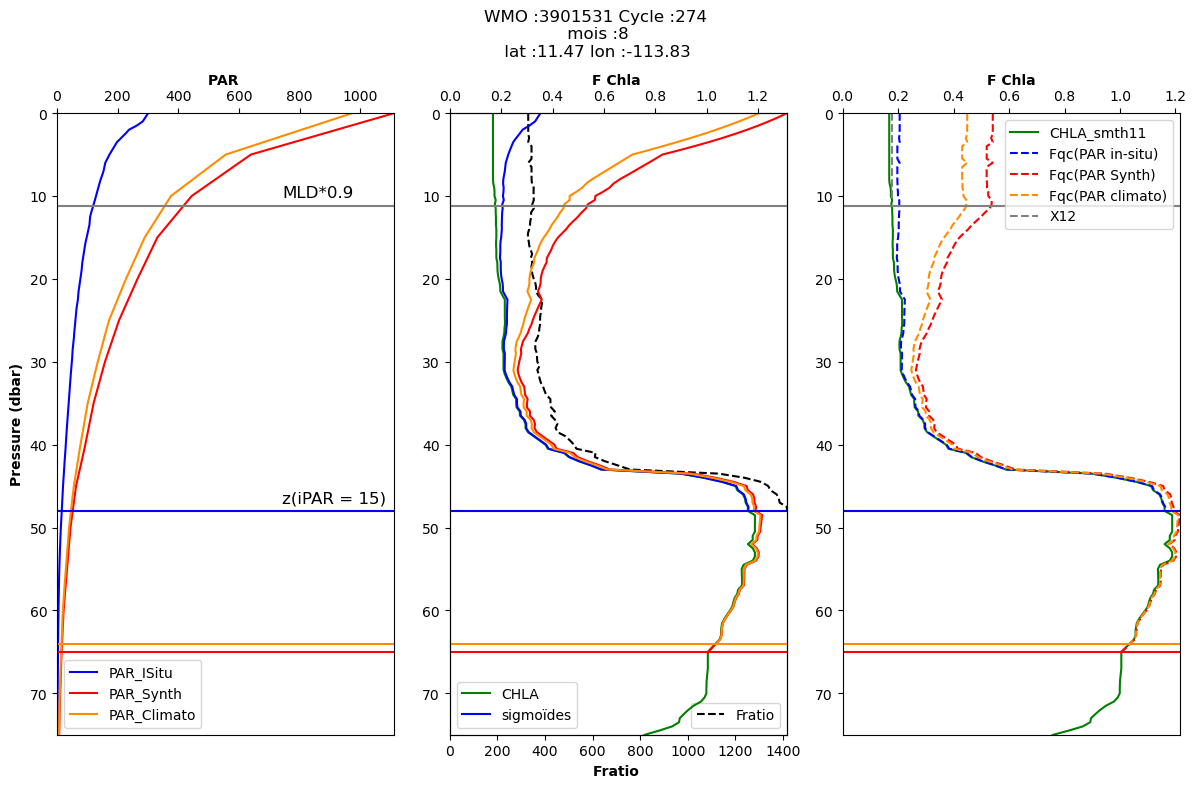

In [11]:
Diff_surface_insitu_SOCA =[]
Diff_surface_insitu_climato =[]
Diff_surface_insitu_X12 =[]

lon_txt = []
lat_txt = []
date_txt = []
WMO_txt = []
Cycle_number_txt = []


zPAR15_txt = []
zPAR15_SOCA_txt = []
zPAR15_climato_txt = []
Fqc_txt = []
Fqc_SOCA_txt = []
Fqc_climato_txt = []
Fqc_X12_txt = []

CHLA_peu_profond = []

# ===============================================================================
# Path to Sprof files
Sprof_path_array = np.array(['D:/DATA/FTP_load_floats/3901531/3901531_Sprof.nc'])
# ===============================================================================
for flotteur in Sprof_path_array:
    
    # Read Netcdf
    data = xr.open_dataset(flotteur) 
    
    # Extract some variables
    time = data['JULD'].values 
    LON = data['LONGITUDE'].values 
    LAT = data['LATITUDE'].values 
    
    WMO = flotteur.split('/')[-1].split('_')[0]
    
    CYCLE_NUMBER = data['CYCLE_NUMBER'].values.astype(int)
    
    
    # Path to SOCA Netcdf (synthetics and climato)
    NC_SOCA_path = 'D:/DATA/data_flotteurs_CSV/Stage M2/SOCA_light/PAR_Outputs/Midday_to_Horaire_py/' + str(WMO) + '_PAR_SOCA_climato_cloche.nc'
    NC_SOCA = xr.open_dataset(NC_SOCA_path)
    
# =============================================================================
# Loop on cycle 

    # for i in range(len(data['CYCLE_NUMBER'].values)): # loop for n profils
    for i in [275]: 
        
        # Local hour
        try :
            # Méthode 1 : avec module timezone = plus gourmand en calcul
            # tf = timezonefinder.TimezoneFinder()
            # timezone = pytz.timezone(tf.certain_timezone_at(lat = LAT[i], lng = LON[i]))
            # date_local = pd.to_datetime(time[i]) + timezone.utcoffset(pd.to_datetime(time[i]))
            
            # Méthode 2 : The fastest(numpy)  bien plus rapide et résultats proches du bon
            # Teeeellement plus rapide : de 1min les 100 profils passage à 10sec deux flotteur
            date_local =  pd.to_datetime(time_UTCtolocal(time[i],LON[i]))
            
            # Avoir le format de la date, permet aussi de détecter les nan si time[i] = Nat
            date_local = pd.to_datetime(date_local.strftime('%Y-%m-%d %H:%M:%S'))
        except :
            print('Long or time NaN ' + str(i))
            # continue_bool = True 
            continue
        

        
        # test si dans tranche horaire 7-18h (évite calcul inutile = fenêtre de SOCA)
        if date_local.hour in np.arange(7,18+1,1):   
            
            print(str(int(i)) + '/' + str(int(np.unique(data['CYCLE_NUMBER'].values)[-1])))
            
            
#%%  PHYSIQUE Conditions
# =============================================================================
# Prise Adjusted si présent et si plus de 75% de QC = 1,2,5,8 (Si QC mauavais pas test du RT car sera forcément pas bon)
# Si Adjusted Absent : 
# Prise de RT et check si profil QC = A ou B      
# =============================================================================
# 1/ Pression
            # Read pres adjusted
            depth = data['PRES_ADJUSTED'].values[i]
            # Check if data
            if not any(~np.isnan(depth)):
                # Read pres RT 
                depth = data['PRES'].values[i]
                if not any(~np.isnan(depth)):
                    print(str(i) +'Pas de mesure de Pression Rt ni ADJ ' )
                    continue
                else:
                     depth_QC = data['PRES_QC'].values[i]
                     depth_QC = depth_QC[~pd.isnull(depth_QC)].astype('int')  
                     profile_QC = np.where ((depth_QC ==1) | (depth_QC==2)|(depth_QC ==5) | (depth_QC==8))
                     percent_depth = 100* len(profile_QC[0])/len(depth_QC)
                     
                     if not percent_depth > 75:
                       print(str(i) +': QC profil PRES trop mauvais : '+ str(percent_depth))
                       continue
            else : 
                 depth_QC = data['PRES_ADJUSTED_QC'].values[i]
                 depth_QC = depth_QC[~pd.isnull(depth_QC)].astype('int')  
                 profile_QC = np.where ((depth_QC ==1) | (depth_QC==2)|(depth_QC ==5) | (depth_QC==8))
                 percent_depth = 100* len(profile_QC[0])/len(depth_QC)
                 
                 if not percent_depth > 75:
                   print(str(i) +': QC profil PRES_ADJ trop mauvais : '+ str(percent_depth))
            
                   continue
      
    # =============================================================================
     
            SP = data['PSAL_ADJUSTED'].values[i]
            if not any(~np.isnan(SP)):
                
                SP = data['PSAL'].values[i]
                if not any(~np.isnan(SP)):
                    print(str(i) +'Pas de mesure de PSAL Rt ni ADJ ' )
                    continue
                
                else:
                    SP_QC = data['PSAL_QC'].values[i]
                    SP_QC = SP_QC[~pd.isnull(SP_QC)].astype('int')  
                    profile_QC = np.where ((SP_QC ==1) | (SP_QC==2)|(SP_QC ==5) | (SP_QC==8))
                    percent_SP = 100* len(profile_QC[0])/len(SP_QC)
                    
                    if not percent_SP > 75:
                      print(str(i) +': QC profil SP trop mauvais : '+ str(percent_SP))
                      continue
                    
            else : 
                 SP_QC = data['PSAL_ADJUSTED_QC'].values[i]
                 SP_QC = SP_QC[~pd.isnull(SP_QC)].astype('int')  
                 profile_QC = np.where ((SP_QC ==1) | (SP_QC==2)|(SP_QC ==5) | (SP_QC==8))
                 percent_SP = 100* len(profile_QC[0])/len(SP_QC)
                 
                 if not percent_SP > 75:
                   print(str(i) +': QC profil SP ADJ trop mauvais : '+ str(percent_SP))
                   continue
            
                  
    # =============================================================================      
            
            temp = data['TEMP_ADJUSTED'].values[i]
            if not any(~np.isnan(temp)):
                temp = data['TEMP'].values[i]
                if not any(~np.isnan(temp)):
                    print(str(i) +'Pas de mesure de TEMP Rt ni ADJ ' )
                    continue
                else:
                    Temp_QC = data['TEMP_QC'].values[i]
                    Temp_QC = Temp_QC[~pd.isnull(Temp_QC)].astype('int')  
                    profile_QC = np.where ((Temp_QC ==1) | (Temp_QC==2)|(Temp_QC ==5) | (Temp_QC==8))
                    percent_Temp = 100* len(profile_QC[0])/len(Temp_QC)
                    
                    if not percent_Temp > 75:
                      print(str(i) +': QC profil TEMP trop mauvais : '+ str(percent_Temp))
                      continue
                    
            else : 
                 Temp_QC = data['TEMP_ADJUSTED_QC'].values[i]
                 Temp_QC = Temp_QC[~pd.isnull(Temp_QC)].astype('int')  
                 profile_QC = np.where ((Temp_QC ==1) | (Temp_QC==2)|(Temp_QC ==5) | (Temp_QC==8))
                 percent_Temp = 100* len(profile_QC[0])/len(Temp_QC)
                 
                 if not percent_Temp > 75:
                   print(str(i) +': QC profil TEMP trop mauvais : '+ str(percent_Temp))
                   continue
            
    
# =============================================================================
#    Compute density and find MLD
# =============================================================================
        
            SA = gsw.SA_from_SP(SP,depth,LON[i],LAT[i])
            CT = gsw.CT_from_t(SA,temp,depth)
            density = gsw.sigma0(SA,CT)
            
            # Rm Nan values
            depth_dens = depth[~np.isnan(density)]
            density = density[~np.isnan(density)]

            if not any(depth_dens<10) or all(depth_dens<10):
                print(str(i) +' Pas de physique en surface : depth_dens[0] = ' + str(depth_dens[:0]))
                continue
            
            try :
                MLD = MLD_Func(density, depth_dens)
            except :
                print('Soucis MLD')
                continue
            
            
#%% Lecture PAR in-situ

# =============================================================================
# Lecture PAR in-situ
# =============================================================================

            PAR = data['DOWNWELLING_PAR_ADJUSTED'].values[i]# prise du PAR Adjusted
            
            # Rm Nan, PAR array shorter
            depth2 = depth[:len(PAR)][~np.isnan(PAR)]
            PAR = PAR[~np.isnan(PAR)]
            PAR_data = '_ADJUSTED_QC'
            
            if not any(~np.isnan(PAR)):
                
                PAR = data['DOWNWELLING_PAR'].values[i]
                depth2 = depth[:len(PAR)][~np.isnan(PAR)]
                PAR = PAR[~np.isnan(PAR)]
                PAR_data = '_QC'
                
                if not any(~np.isnan(PAR)):
                    print(str(i) +': Pas de profil de PAR ni RT ni ADJ (descendant ?)')
                    continue


            if not any(PAR <15): 
                print(str(i) +': Le flotteur ne voit pas le zPAR15')
                continue
            
            # Ajout de cette condition pour éviter des profils avec une lumière trop faible
            if not PAR[0] > 15 :
                print('PAR de surface trop faible')
                continue

            # Linear interpolation every 0.5m   
            PAR_inter, depth_inter_PAR  = interpol(PAR, depth2, 0.5)

            try :
                index_Zeu = np.absolute(PAR_inter-15).argmin()
                
                if not  int(PAR_inter[index_Zeu] ) in np.arange(11,19,1) :
                    # Si PAR à zPAR15 trop éloiné de 15
                    # try :
                    #     # Mais cette technique a trop tendance à rejeter des profils si pas de valeur à 15,..
                    # et ne sert à rien de tenter dans cette configuration
                    #     index_Zeu = np.min(np.where(PAR_inter.astype(int) == 15))
                    # except:
                        print('zPAR15 éloigné de zPAR = 15')
                        
                        continue
            except :
                print('Prblm sur index zPAR15')
                continue

            zPAR15 = depth_inter_PAR[index_Zeu]
            
            # Ajout condition len(PAR_inter[:np.absolute(depth2 - zPAR15).argmin()]) : 
                #car si len() = 0 dans les QC crée des erreur (et veut aussi dire que zPAR15 trop en surface)
            if zPAR15 < 5 or len(PAR_inter[:np.absolute(depth2 - zPAR15).argmin()]) == 0:
                print('zPAR15 trop en surface : ' + str(zPAR15))
                continue
                
# =============================================================================
# PAR QC           
# =============================================================================
            PAR_QC =   data[ 'DOWNWELLING_PAR' + PAR_data ].values[i] #Prise des QC du profils adj ou Rt selon choix precedent
            # PAR_QC = PAR_QC[~pd.isnull(PAR_QC)].astype('int')  
            PAR_QC = PAR_QC[~np.isnan(data['DOWNWELLING_PAR' + PAR_data.replace('_QC','') ].values[i])].astype('int')

            
            if PAR_data == '_ADJUSTED_QC':
                profile_QC = np.where((PAR_QC[:np.absolute(depth2 - zPAR15).argmin()]   ==1) | (PAR_QC[:np.absolute(depth2 - zPAR15).argmin()]==2)|
                                      (PAR_QC[:np.absolute(depth2 - zPAR15).argmin()]==5)| (PAR_QC[:np.absolute(depth2 - zPAR15).argmin()]==8)) #prise de surface à zPAR15 | = or
                percent_PAR = 100* len(profile_QC[0])/len(PAR_QC[:np.absolute(depth2 - zPAR15).argmin()])
                
                # =============================================================================                 
                # Delete PAR values with QC = 3 or 4 
                mask = (PAR_QC == 3) | (PAR_QC == 4)
                    
                PAR = np.delete(PAR , mask, axis=None    )
                depth2 = np.delete(depth2 , mask, axis=None    )
                # =============================================================================
                
                
            else : 
                profile_QC = np.where((PAR_QC[:np.absolute(depth2 - zPAR15).argmin()]   ==0) |(PAR_QC[:np.absolute(depth2 - zPAR15).argmin()]   ==1) | 
                                      (PAR_QC[:np.absolute(depth2 - zPAR15).argmin()]==2))
                percent_PAR = 100* len(profile_QC[0])/len(PAR_QC[:np.absolute(depth2 - zPAR15).argmin()])
             
                # =============================================================================                 
                # Delete PAR values with QC = 4 
                mask = (PAR_QC == 4)
                    
                PAR = np.delete(PAR , mask, axis=None    )
                depth2 = np.delete(depth2 , mask, axis=None    )
                # =============================================================================
            if not percent_PAR > 75:
               print(str(i) +': QC profil PAR trop mauvais : '+ str(percent_PAR))
               continue
            
            
            # Linear interpolation (Pour les valeurs retirées par QC = 3 | 4)
            PAR_inter, depth_inter_PAR  = interpol(PAR, depth2, 0.5)
            
            
            # Meilleure méthode, permet de ne pas avoir de nan values aux extremités
            # Alors que pour CHLA et bbp il est préferable de supposer une constance dans la couche superficielle
            PAR_smth_inter = median_filter(PAR_inter, 11, mode = 'nearest')
            
            PAR = PAR_smth_inter
            
          
# =============================================================================
# Lecture PAR SOCA
# =============================================================================

        
        # Lecture dans le NC du PAR où la cloche a été appliquée avec SOCA midday to horaire
            PAR_SOCA = NC_SOCA['PAR_SOCA'][i,:]
        # Check si a été remplit
            if np.all(np.isnan(PAR_SOCA)):
                print('Pas de données PAR SOCA dans le NC' )
                continue
            Depth_SOCA = np.arange(0, 255, 5)
            
# =============================================================================              
            # Chgmt pour linear, car cubic passe au dessus
            fit_SOCA = interp1d(Depth_SOCA, PAR_SOCA, kind='linear') 
            prof_05 = np.arange(0,250,0.5)
            Soca_Res05 = fit_SOCA(prof_05)


            try:
                index_Zeu_SOCA = np.absolute(Soca_Res05 - 15).argmin()
            except :
                try :
                    index_Zeu_SOCA = np.min(np.where(Soca_Res05.astype(int) == 15))
                except:
                    print('Prblm sur index zPAR15')
                    continue
            
            
            zPAR15_SOCA = prof_05[index_Zeu_SOCA]


# =============================================================================
# Lecture PAR Climato
# =============================================================================
    
        # Lecture dans le NC
            PAR_climato = NC_SOCA['PAR_climato'][i,:]
        # Check si a été remplit
            if np.all(np.isnan(PAR_climato)):
                print('Pas de données climato')
                continue
            
            Depth_climato = np.arange(0, 255, 5)
    # ============================================================================= 
            
            fit_climato = interp1d(Depth_climato, PAR_climato , kind='linear') 
            prof_05 = np.arange(0,250,0.5)
            Climato_Res05 = fit_climato(prof_05)

            zPAR15_climato = prof_05[np.absolute(Climato_Res05-15).argmin()]




# =============================================================================
#%% Bbp  


# =============================================================================
# Profils QC au dela de Zpar 15 in situ
# =============================================================================  
  
            Bbp = data['BBP700_ADJUSTED'].values[i]
            depth3 = depth[~np.isnan(Bbp)]
            Bbp = Bbp[~np.isnan(Bbp)]
            Bbp_data = '_ADJUSTED_QC'
            
            if not any(~np.isnan(Bbp)) or len(Bbp[:np.absolute(depth3 - zPAR15).argmin()])<3 : #Si moins de 3 valeurs au dessus de zPAR15
    
                Bbp = data['BBP700'].values[i]
                depth3 = depth[~np.isnan(Bbp)]
                Bbp = Bbp[~np.isnan(Bbp)]
                Bbp_data = '_QC'
                
                if not any(~np.isnan(Bbp))  :
                    print(str(i) +' Pas de profil de Bbp ')
                    continue
                elif len(Bbp[:np.absolute(depth3 - zPAR15).argmin()])<3 :
                    print(str(i) + ' bbp que <3 valeurs (ADJ et RT)')
                    continue
    
            Bbp_QC =   data['BBP700'+ Bbp_data ].values[i] #Prise des QC du profils adj ou Rt selon choix precedent
            # Bbp_QC = Bbp_QC[~pd.isnull(Bbp_QC)].astype('int')  
            # Pour être sur que les deux array ait la même longueur : 
                # J'ai eu une erreur sur WMO : 4901802 i = 24
                # /!\ A bien prendre le bon bbp DATA où '_QC' retiré
            Bbp_QC = Bbp_QC[~np.isnan(data['BBP700' + Bbp_data.replace('_QC','') ].values[i])].astype('int')
            
            if Bbp_data == '_ADJUSTED_QC':
                profile_QC = np.where((Bbp_QC[:np.absolute(depth3 - zPAR15).argmin()]   ==1) | (Bbp_QC[:np.absolute(depth3 - zPAR15).argmin()]==2)| 
                                      (Bbp_QC[:np.absolute(depth3 - zPAR15).argmin()]==5)| (Bbp_QC[:np.absolute(depth3 - zPAR15).argmin()]==8)) 
                percent_Bbp = 100* len(profile_QC[0])/len(Bbp_QC[:np.absolute(depth3 - zPAR15).argmin()])
                
                # =============================================================================                 
                # Delete bbp values with QC = 3 or 4 
                mask = (Bbp_QC == 3) | (Bbp_QC == 4)
                    
                Bbp = np.delete(Bbp , mask, axis=None    )
                depth3 = np.delete(depth3 , mask, axis=None    )

                # =============================================================================                
                
            else:
                profile_QC = np.where((Bbp_QC[:np.absolute(depth3 - zPAR15).argmin()]   ==0) |(Bbp_QC[:np.absolute(depth3 - zPAR15).argmin()]   ==1) | 
                                      (Bbp_QC[:np.absolute(depth3 - zPAR15).argmin()]==2)) #prise de surface à zPAR15 (| = or)
                percent_Bbp = 100* len(profile_QC[0])/len(Bbp_QC[:np.absolute(depth3 - zPAR15).argmin()])
                
                # =============================================================================                 
                # Delete bbp values with QC = 4 (comme CHLA QC=3 potentiellement mauvais et ajustable donc au cas où on laisse)
                mask =  (Bbp_QC == 4)
                    
                Bbp = np.delete(Bbp , mask, axis=None    )
                depth3 = np.delete(depth3 , mask, axis=None    )

                # =============================================================================
                
                
            if not percent_Bbp > 75:
               print(str(i) +': QC profil Bbp trop mauvais : '+ str(percent_Bbp))
               continue
           
            if not any(depth3 <15) :
               print(str(i) +' Pas de Bbp au dessus de 15m')
               # Sinon interpolation tous les 0.5 assume homogeneité dans une trop grosse couche d'eau
               continue

            # Linear interpolation every 0.5m
            Bbp_inter, depth_inter_Bbp  = interpol(Bbp, depth3, 0.5) 

            #Smooth mobil median 11 
            Bbp_smth_inter = median_filter(Bbp_inter, 11, mode = 'nearest')
             
            # Nan values at surface => I assume that it's constant in the first 2 meter 
            index = np.array([0,1,2,3])
            Bbp_smth_inter[index] = Bbp_smth_inter[np.max(index)+1] 
            
            Bbp = Bbp_smth_inter

#%% Chlorophylle

# =============================================================================
# Profils QC au dela de Zpar 15 (Pour les QC choix de prise celui de flotteur) in situ
# ============================================================================= 
           
            CHLA_raw = data['CHLA'].values[i]
            depth1 = depth[~np.isnan(CHLA_raw)]
            CHLA_raw = CHLA_raw[~np.isnan(CHLA_raw)]
             
            if not any(~np.isnan(CHLA_raw))  :
                print(str(i) +' Pas de profil de Fluo')
                continue
            elif len(CHLA_raw[:np.absolute(depth1 - zPAR15).argmin()])<3 :
                  print(str(i) +'Fluo que <3 valeurs au dessus de zPAR15')
                  continue
             
            CHL_QC =   data['CHLA_QC' ].values[i] 
            # CHL_QC = CHL_QC[~pd.isnull(CHL_QC)].astype('int')
            # Même chose que précedemment
            CHL_QC = CHL_QC[~np.isnan(data['CHLA'].values[i])].astype('int')

            
            # Pour la CHL on prend aussi le flag 3 car représente valeurs ajustables" et donc celles quenchées
            profile_QC = np.where((CHL_QC[:np.absolute(depth1 - zPAR15).argmin()]   ==0) |(CHL_QC[:np.absolute(depth1 - zPAR15).argmin()]   ==1) | 
                                    (CHL_QC[:np.absolute(depth1 - zPAR15).argmin()]==2) | (CHL_QC[:np.absolute(depth1 - zPAR15).argmin()]   ==3)) 
            percent_CHL = 100* len(profile_QC[0])/len(CHL_QC[:np.absolute(depth1 - zPAR15).argmin()])
            
            # =============================================================================                 
            # Delete CHLA_raw values with QC = 4 (car QC = 3 représente les valeurs devant être ajustées)
            mask = CHL_QC == 4
                
            CHLA_raw = np.delete(CHLA_raw , mask, axis=None    )
            depth1 = np.delete(depth1 , mask, axis=None    )

            # =============================================================================
            
            
            if not percent_CHL > 75:
               print(str(i) +': QC profil CHL trop mauvais : '+ str(percent_CHL))
               continue

            if not any(depth1 <15) :
               print(str(i) +' Pas de CHL au dessus de 15')
               # Sinon interpolation tous les 0.5 assume homogeneité dans une trop grosse couche d'eau
               continue


             # Linear interpolation every 0.5m    
            Chlraw_inter, depth_inter_CHL  = interpol(CHLA_raw, depth1, 0.5)
            
            #Smooth mobil median 11 => Advise from XING 2018
            Chlraw_smth_inter = median_filter(Chlraw_inter, 11, mode = 'nearest')
            
            # Nan values at surface => I assume that it's constant in the first 2 meter 
            index = np.array([0,1,2,3])
            Chlraw_smth_inter[index] = Chlraw_smth_inter[np.max(index)+1]
            
            
            Chla = Chlraw_smth_inter
            

            if any(Chla[:np.absolute(depth_inter_CHL - 15).argmin()]<0.02):
                print('problm CHLA en surface inf à 0.02')
                continue
      
    
# ============================================================================       
#%% NPQ corr
              
            # Flotteur 5906767 : A partir du cycle 54, les mesure de CHLA sont moins profondes que celles de lumière
            # Dans ces cas là on ne fait pas de correction
            # Il faudrait au minimum que les données de CHLA soit plus profondes que zPAR15 (+20m?)
            if not depth_inter_CHL[-1] > zPAR15 +20 :
                print('Données de CHLA pas assez profondes ' + str(depth_inter_CHL[-1]) + ' zPAR15 : '+str(zPAR15))
                CHLA_peu_profond.append(str(WMO) +' '+ str(i))
                continue
# =============================================================================
#  In situ
# =============================================================================


            Fqc , depth_Fqc, Fq , Fratio, zPAR15 ,XB18 =  NPQ.NPQ_Corr ( depth_inter_CHL , PAR , MLD, Chla , Bbp)


# =============================================================================
#  _SOCA
# =============================================================================


            Fqc_SOCA , depth_Fqc_SOCA, Fq , Fratio, zPAR15_SOCA ,XB18_SOCA =  NPQ.NPQ_Corr (prof_05  , Soca_Res05 , MLD, Chla , Bbp)



# =============================================================================
#  _climato
# =============================================================================


            Fqc_climato , depth_Fqc_climato, Fq , Fratio, zPAR15_climato , XB18_climato =  NPQ.NPQ_Corr ( prof_05 , Climato_Res05 , MLD, Chla , Bbp)


# =============================================================================
#  _X12
# =============================================================================


            Fqc_X12 , depth_Fqc_X12  =  NPQ.X12 (depth_inter_CHL , MLD*0.9, Chla )

# =============================================================================
#%% FIGURE profile


            if 1==1 :

                
                plt.figure(figsize=[12,8])
                plt.subplot(131)
            
                plt.plot(PAR,depth_inter_PAR,'b',label='PAR_ISitu',alpha=1)
                plt.plot(Soca_Res05,prof_05,'red',label='PAR_Synth',alpha= 1)
                plt.plot(Climato_Res05,prof_05,'darkorange',label='PAR_Climato',alpha= 1)
        
                plt.axhline(y= zPAR15,color='b')
                plt.axhline(y= zPAR15_SOCA,color='r')
                plt.axhline(y= zPAR15_climato,color='darkorange')
                plt.axhline(y= MLD*0.9,color='grey')
                
                maxi = np.max([np.max(PAR_inter),np.max(Soca_Res05),np.max(Climato_Res05)])
                
                plt.annotate('z(iPAR = 15)',xy=(0, zPAR15), xycoords='data',xytext=(maxi*2/3, zPAR15-1), fontsize=12,color='k')
                plt.annotate('MLD*0.9',xy=(0, MLD*0.9), xycoords='data',xytext=(maxi*2/3, MLD*0.9-1), fontsize=12,color='k')
                
                plt.axis([0,maxi,0,np.max([MLD*0.9,zPAR15,zPAR15_SOCA,zPAR15_climato])+10])

                plt.xlabel('PAR ',loc='center',fontweight='semibold')
                ax = plt.gca()
                ax.xaxis.tick_top()
                ax.xaxis.set_label_position('top')
                
                plt.ylabel('Pressure (dbar)',fontweight='semibold')
                plt.legend(loc='best') #Auto
                
                plt.gca().invert_yaxis()
                
    # =============================================================================  # ============================================================================= 
             
                plt.subplot(132)
                # Fratio = Chla/Bbp
                Fratio = Chla[:np.absolute(PAR-15).argmin()+1]/Bbp[:np.absolute(PAR-15).argmin()+1]
                
                plt.plot(Fratio,depth_inter_Bbp[:np.absolute(PAR-15).argmin()+1],'k', label = 'Fratio', linestyle ='--')
                plt.xlim([np.min([np.nanmin(Fratio),0]),np.nanmax(Fratio)])
                plt.axvline(x = 0, color = 'k', alpha =0.1, linestyle ='--')
                # plt.plot(Bbp,depth_inter_Bbp,'k', linestyle ='--', label = 'bbp')
                # plt.xlim([0,np.nanmax(Bbp)])
                plt.legend(loc='lower right')
                plt.xlabel('Fratio ',loc='center',fontweight='semibold')
                
                if MLD*0.9<zPAR15:
                    
                    plt.twiny()
                    
                    plt.plot(Chla, depth_inter_CHL ,color='g', label='CHLA')
                    
                    plt.plot(XB18,depth_inter_CHL[:len(XB18)],color='b', label = 'sigmoïdes')
                    plt.plot(XB18_SOCA,depth_inter_CHL[:len(XB18_SOCA)],color='r')
                    plt.plot(XB18_climato,depth_inter_CHL[:len(XB18_climato)],color='darkorange')
                    
                    plt.xlim([0,np.max([np.nanmax(Chla),np.nanmax(XB18),np.max(XB18_SOCA),np.max(XB18_climato)])])
                    
                plt.ylim([0,np.max([MLD*0.9,zPAR15,zPAR15_SOCA,zPAR15_climato])+10])
                
                plt.axhline(y= zPAR15,color='b')
                plt.axhline(y= zPAR15_SOCA,color='r')
                plt.axhline(y= zPAR15_climato,color='darkorange')
     
                plt.axhline(y= MLD*0.9,color='grey')
                
                plt.xlabel('F Chla ',loc='center',fontweight='semibold')
                
                plt.legend(loc='best')
                plt.gca().invert_yaxis()
                
    # =============================================================================  # =============================================================================   
                plt.subplot(133)

                plt.plot(Chla, depth_inter_CHL ,color='g', label='CHLA_smth11')
            
                plt.plot(Fqc,depth_Fqc,'b',label='Fqc(PAR in-situ)',linestyle='dashed')
                plt.plot(Fqc_SOCA,depth_Fqc_SOCA,'r',label='Fqc(PAR Synth)',linestyle='dashed')           
                plt.plot(Fqc_climato,depth_Fqc_climato,'darkorange',label='Fqc(PAR climato)',linestyle='dashed') 
                plt.plot(Fqc_X12,depth_Fqc_X12,color='grey',label='X12',linestyle='dashed') 
                
                plt.axhline(y= zPAR15,color='b')
                plt.axhline(y= zPAR15_SOCA,color='r')
                plt.axhline(y= zPAR15_climato,color='darkorange')
                plt.axhline(y= MLD*0.9,color='grey')
                
                plt.axis([0,np.max([np.nanmax(Chla),np.nanmax(Fqc),np.max(Fqc_SOCA),  np.max(Fqc_climato) ]  ),0,np.max([MLD*0.9,zPAR15,zPAR15_SOCA,zPAR15_climato])+10])
                plt.gca().invert_yaxis()

                plt.xlabel('F Chla',loc='center',fontweight='semibold')
                ax = plt.gca()
                ax.xaxis.tick_top()
                ax.xaxis.set_label_position('top')
                plt.legend(loc='best') #Auto
                plt.suptitle('WMO :' + str(WMO)+ ' Cycle :' +str(CYCLE_NUMBER[i]) +'\n mois :'+str(date_local.month) + '\n lat :'+str(round(LAT[i],2))+' lon :'+str(round(LON[i],2)))
    
                plt.tight_layout()
                namefig = str(flotteur) + '_' +str(i) + '_WMO_' + str(WMO)
                # plt.savefig('C:/Users/OMTABmezz/Pictures/M2/Cath/' + namefig + '_High' , dpi=150   , format='png')
                # plt.close()
                
# =============================================================================              
#%% Save Diff

            # if not np.isnan(Fqc[0]) :
                
            Diff_surface_insitu_SOCA.append(abs(Fqc_SOCA[0]-Fqc[0])/Fqc[0])
            Diff_surface_insitu_climato.append(abs(Fqc_climato[0]-Fqc[0])/Fqc[0])
            Diff_surface_insitu_X12.append(abs(Fqc_X12[0]-Fqc[0])/Fqc[0])     

            lon_txt.append(LON[i])
            lat_txt.append(LAT[i])
            date_txt.append(date_local.strftime('%Y-%m-%d %H:%M:%S'))
            WMO_txt.append(WMO)
            Cycle_number_txt.append(CYCLE_NUMBER[i])
            
            zPAR15_txt.append(zPAR15)
            zPAR15_SOCA_txt.append(zPAR15_SOCA)
            zPAR15_climato_txt.append(zPAR15_climato)
            
            Fqc_txt.append(Fqc[0])
            Fqc_SOCA_txt.append(Fqc_SOCA[0])
            Fqc_climato_txt.append(Fqc_climato[0])
            Fqc_X12_txt.append(Fqc_X12[0])
            


#import sys
#sys.exit() 
# Pour forcer l'arrêt du script ici

# data = {"Diff_surface_insitu_SOCA" : Diff_surface_insitu_SOCA , "Diff_surface_insitu_climato" : Diff_surface_insitu_climato , "Diff_surface_insitu_X12":Diff_surface_insitu_X12 ,
#         "longitude" :lon_txt ,"latitude" : lat_txt , "date" : date_txt, 'WMO' : WMO_txt , 'Cycle' : Cycle_number_txt, 'zPAR15_txt' : zPAR15_txt ,'zPAR15_SOCA_txt' :zPAR15_SOCA_txt  ,'zPAR15_climato_txt' : zPAR15_climato_txt ,
#         'Fqc_txt' : Fqc_txt ,'Fqc_SOCA_txt' :Fqc_SOCA_txt  ,'Fqc_climato_txt' : Fqc_climato_txt ,'Fqc_X12_txt' : Fqc_X12_txt } 
# data = pd.DataFrame(data) 

# data.to_csv('D:/DATA/data_flotteurs_CSV/Stage M2/Save_work_cath_modif_QC.csv', header=True, index=None, sep=';', mode='a')